In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np

selected_data=pd.read_csv('selected_data.csv')

In [2]:
# 1. 향후 1년간의 주가 데이터 가져오기 (2021년 데이터)
tickers = selected_data.columns[1:]  # 'Date' 열을 제외한 티커 목록
start_date = "2021-01-01"
end_date = "2021-12-31"

In [3]:
# 각 티커에 대한 데이터 다운로드
future_data = yf.download(tickers=list(tickers), start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  91 of 91 completed


In [4]:
# 2021년 첫 거래일의 주가
first_price_2021 = future_data.loc['2021-01-04']

In [5]:
# 2021년 마지막 거래일의 주가
last_price_2021 = future_data.loc['2021-12-30']

# 3. 연간 수익률 계산
annual_returns = (last_price_2021 - first_price_2021) / first_price_2021 * 100

# 결과 출력
print("Annual returns for 2021:\n", annual_returns)

Annual returns for 2021:
 Ticker
ABBV    35.138933
ABT     31.224877
ACN     63.356916
ADP     48.096901
AEP     12.673526
          ...    
WELL    43.916758
WFC     64.159872
WM      46.669452
WMB     37.378913
XOM     55.489256
Length: 91, dtype: float64


In [6]:
# 모든 종목들의 평균 연간 수익률 계산
average_annual_return = annual_returns.mean()

# 결과 출력
print("Average annual return for 2021:", average_annual_return, "%")

Average annual return for 2021: 39.13046110646251 %


### (매출성장률과 eps성장률이 low) 종목의 평균수익률 38%

### (매출성장률과 eps성장률이 high) 종목의 평균수익률 39%

### 현대 포트폴리오 이론을 통한 포트폴리오 최적화

In [7]:
# Date 열을 제외하고 나머지 숫자 열들에 대해서만 일간 수익률을 계산
returns = future_data.pct_change().dropna()

In [8]:
# 연간 수익률 계산
mean_returns = returns.mean() * 252

# 공분산 행렬 계산
cov_matrix = returns.cov() * 252

# 출력으로 확인
print("Mean Returns:\n", mean_returns)
print("Covariance Matrix:\n", cov_matrix)

Mean Returns:
 Ticker
ABBV    0.324078
ABT     0.296850
ACN     0.514393
ADP     0.413794
AEP     0.133791
          ...   
WELL    0.402868
WFC     0.556865
WM      0.399164
WMB     0.346263
XOM     0.488782
Length: 91, dtype: float64
Covariance Matrix:
 Ticker      ABBV       ABT       ACN       ADP       AEP       AME      ANET  \
Ticker                                                                         
ABBV    0.040502  0.010270  0.011222  0.010397  0.006754  0.012689  0.017715   
ABT     0.010270  0.045248  0.014058  0.007225  0.005502  0.007811  0.017012   
ACN     0.011222  0.014058  0.038841  0.018909  0.007034  0.020239  0.020589   
ADP     0.010397  0.007225  0.018909  0.035429  0.010237  0.017654  0.022233   
AEP     0.006754  0.005502  0.007034  0.010237  0.027043  0.008178  0.003308   
...          ...       ...       ...       ...       ...       ...       ...   
WELL    0.009750  0.000636  0.017507  0.013777  0.013876  0.020146  0.008241   
WFC     0.016636 -0.0046

In [9]:
# 포트폴리오의 기대 수익률과 변동성을 계산하는 함수
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, volatility

In [10]:
# 제약 조건: 모든 가중치의 합은 1이어야 함
def check_sum(weights):
    return np.sum(weights) - 1

In [11]:
# 초기 가중치 설정
num_assets = len(mean_returns)
args = (mean_returns, cov_matrix)
constraints = ({'type': 'eq', 'fun': check_sum})
bound = (0.0, 1.0)
bounds = tuple(bound for asset in range(num_assets))

In [12]:
# 샤프 비율 최대화 함수
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

In [13]:
from scipy.optimize import minimize

# 수학적 최적화를 통한 샤프 비율 최대화
result = minimize(negative_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                  method='SLSQP', bounds=bounds, constraints=constraints) #가중치로 자산의 수(num_assets)만큼 균등하게 가중치를 배분

optimal_weights = result.x

In [14]:
# 최적 포트폴리오의 성능 계산
opt_return, opt_volatility = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
opt_sharpe = (opt_return - 0.01) / opt_volatility

In [15]:
# 효율적 프론티어 계산 및 시각화
def minimize_volatility(weights):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

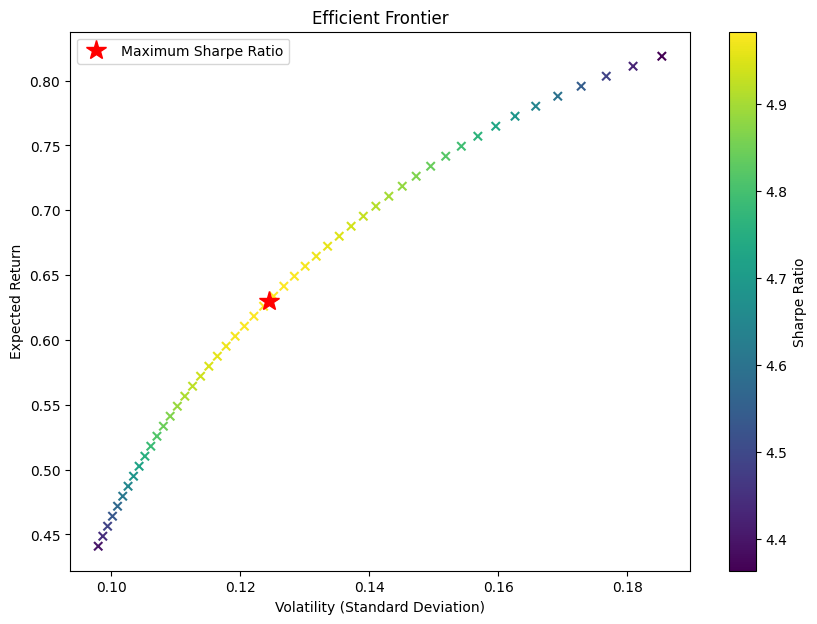

In [16]:
import matplotlib.pyplot as plt

# 효율적 프론티어 계산 및 시각화
target_returns = np.linspace(opt_return * 0.7, opt_return * 1.3, 50)
efficient_volatilities = []

for target_return in target_returns:
    constraints = ({'type': 'eq', 'fun': check_sum},
                   {'type': 'eq', 'fun': lambda w: portfolio_performance(w, mean_returns, cov_matrix)[0] - target_return})
    result = minimize(minimize_volatility, num_assets*[1./num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_volatilities.append(result['fun'])

# 그래프 시각화
plt.figure(figsize=(10, 7))
plt.scatter(efficient_volatilities, target_returns, c=(np.array(target_returns)-0.01)/np.array(efficient_volatilities), cmap='viridis', marker='x')
plt.plot(opt_volatility, opt_return, 'r*', markersize=15.0, label='Maximum Sharpe Ratio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.show()

In [17]:
# 각 자산의 투자 비중 출력
print("\nOptimal Portfolio Weights:")
for ticker, weight in zip(future_data, optimal_weights):
    print(f"{ticker}: {weight:.4f}")


Optimal Portfolio Weights:
ABBV: 0.0036
ABT: 0.0082
ACN: 0.0000
ADP: 0.0000
AEP: 0.0000
AME: 0.0000
ANET: 0.0466
AON: 0.0000
AOS: 0.0000
AVGO: 0.0000
AVY: 0.0000
AXP: 0.0000
AZO: 0.0817
BBY: 0.0000
BDX: 0.0000
BIIB: 0.0000
BKNG: 0.0000
CAG: 0.0000
CB: 0.0000
CCL: 0.0000
CLX: 0.0000
CMS: 0.0000
CNP: 0.0000
COR: 0.0000
CTSH: 0.0000
DGX: 0.1071
DXCM: 0.0000
EIX: 0.0000
EPAM: 0.0129
EQR: 0.0000
ETSY: 0.0000
EXR: 0.2025
FE: 0.0195
FITB: 0.0000
FOXA: 0.0014
FTNT: 0.0359
FTV: 0.0000
GEN: 0.0000
GLW: 0.0000
GM: 0.0000
HBAN: 0.0000
HCA: 0.0000
HES: 0.0000
INTU: 0.0170
IQV: 0.0000
IRM: 0.0949
JKHY: 0.0000
JPM: 0.0000
K: 0.0000
LVS: 0.0000
MAA: 0.1066
MCHP: 0.0000
MCO: 0.0000
MKTX: 0.0000
MMC: 0.0004
MNST: 0.0000
MPC: 0.0450
MRK: 0.0000
MSCI: 0.0000
MSFT: 0.0000
MSI: 0.0000
NDAQ: 0.0000
NFLX: 0.0000
NSC: 0.0000
ODFL: 0.0228
OKE: 0.0000
OXY: 0.0064
PANW: 0.0236
PAYX: 0.0000
PFG: 0.0000
PSA: 0.0732
PTC: 0.0000
PYPL: 0.0000
ROL: 0.0000
ROP: 0.0000
SBAC: 0.0000
STLD: 0.0146
STZ: 0.0000
TMO: 0.0330
T

In [18]:
# 결과 출력
print("Optimal Portfolio Performance:")
print("Expected Annual Return: {:.2f}%".format(opt_return * 100))
print("Annual Volatility: {:.2f}%".format(opt_volatility * 100))
print("Sharpe Ratio: {:.2f}".format(opt_sharpe))

Optimal Portfolio Performance:
Expected Annual Return: 62.99%
Annual Volatility: 12.44%
Sharpe Ratio: 4.98


# 결과

### 1번 시나리오 ( 매출,eps 성장률 모두 high )
* 2020년 수익률 : 111.88%
* 2021년 수익률 : 62.98%

### 2번 시나리오 (매출,eps 성장률 모두 low)
* 2020년 수익률 : 70.91%
* 2021년 수익률 : 52.79%

매출 성장률과 eps 성장률이 낮으면 수익률도 낮아진다

포트폴리오 최적화 적용 이전 수익률 차이 1% -> 최적화 적용후 수익률 차이 10%